In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## importing neccasary libraries

In [ ]:
!pip install numpy 
!pip install pandas 
!pip install cufflinks 
!pip install matplotlib

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 

import cufflinks as cf
cf.set_config_file(offline = True)
cf.go_offline()

### Thing to note while backtesting is u have to have a process or think u have to have a production line wich make your backtests faster and more accurate 
* first is to get the data 
* do some data cleaning if required 
* then do factor caculation in the dataframe itself before just diving into signal genration algo if possible 
* generate signal 
* Then calculate performence metrics on backtested results 

## lets load a stock data 

In [3]:
df = pd.read_csv("DailyHDFCcash.csv",index_col = 0,parse_dates=True)["Close"].to_frame()
df = df.loc["2010":].copy()

In [11]:
df.head()

,Close
Date,
2010-01-04,534.87
2010-01-05,536.69
2010-01-06,539.27
2010-01-07,529.23
2010-01-08,520.01


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2491 entries, 2010-01-04 to 2020-01-17
Data columns (total 1 columns):
Close    2491 non-null float64
dtypes: float64(1)
memory usage: 38.9 KB


## preparing data before generating signal 
* as our data is already clean we need to calculate some factors at data level wich will be used as production line  
* factors we need for bollinger band stratergy 
  * rolling standard deviation upper and lower bands 
  * rolling mean

In [4]:
## we have to calculate rolling mean 
# we also have to caclulate rolling std 

df["rolling_mean"] = df.Close.rolling(30).mean()
df['rolling_std'] = df.Close.rolling(30).std()

# calculating rolling upper band one 2std above mena  and other 2.5 std above from mean 
df['upper_band'] = df.rolling_mean + (df.rolling_std * 2)
df["upper_band2"] = df.rolling_mean + (df.rolling_std * 3)


# calculating two rolling lower band one 2std below mean and other 2.5 std deviations from mean 
df['lower_band'] = df.rolling_mean - (df.rolling_std * 2)
df['lower_band2'] = df.rolling_mean - (df.rolling_std * 3)

# craeting columns to store signals
df["short_trades"] = 0
df["long_trades"] = 0

# creting column to store trade wise pnl
df["short_pnl"] = 0
df['long_pnl'] = 0

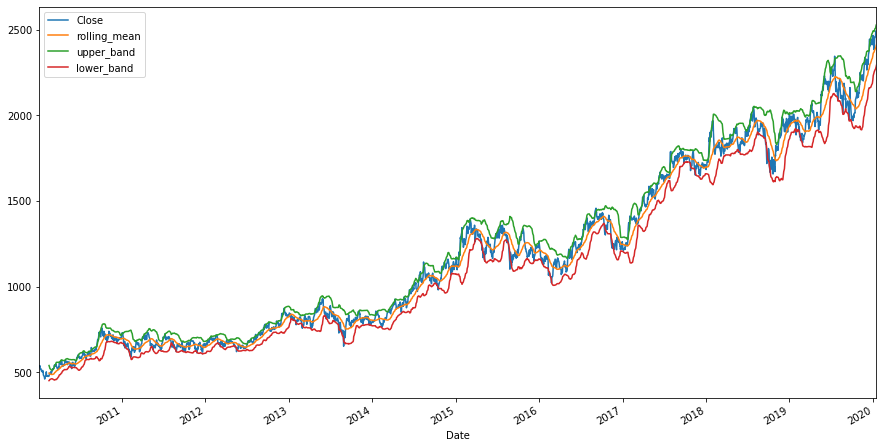

In [5]:
df[["Close","rolling_mean","upper_band","lower_band"]].plot(figsize = (15,8))
plt.show()

In [6]:
#first will drop columns with nan values 
df.dropna(inplace=True)
df.head()

,Close,rolling_mean,rolling_std,upper_band,upper_band2,lower_band,lower_band2,short_trades,long_trades,short_pnl,long_pnl
Date,,,,,,,,,,,
2010-02-15,478.18,495.876000,22.091542,540.059085,562.150627,451.692915,429.601373,0,0,0,0
2010-02-16,485.64,494.235000,20.890939,536.016878,556.907816,452.453122,431.562184,0,0,0,0
2010-02-17,492.79,492.771667,19.290813,531.353294,550.644107,454.190040,434.899226,0,0,0,0
2010-02-18,496.19,491.335667,17.200297,525.736260,542.936557,456.935073,439.734776,0,0,0,0
2010-02-19,496.00,490.228000,15.678476,521.584952,537.263429,458.871048,443.192571,0,0,0,0


In [7]:
short_entry = 0
short_exit = 0

long_entry = 0
long_exit = 0

# creating some flags 
entered_short = False
entered_long = False
    

for iter_count,day in enumerate(df.index):
    

    # first lets check for short
    if (df.iloc[iter_count].loc["Close"] > df.iloc[iter_count].loc["upper_band"]) and (df.iloc[iter_count].loc["Close"] < df.iloc[iter_count].loc["upper_band2"]) and (entered_short == False):
        # we short the stock
        df.iloc[iter_count,7] = -1
        entered_short = True
        
        #storing short entry price
        short_entry = df.iloc[iter_count].loc["Close"]
        
    #cheking for short target 
    elif (df.iloc[iter_count].loc["Close"] <= df.iloc[iter_count].loc["rolling_mean"]) and (entered_short == True):
        
        # we exit the trade as target met
        df.iloc[iter_count,7] = 1
        entered_short = False
        
        #storing short exit price 
        short_exit = df.iloc[iter_count].loc["Close"]
        
        #calculating pnl 
        df.iloc[iter_count,9] = short_entry - short_exit

    # checking for short trade stop 
    elif (df.iloc[iter_count].loc["Close"] >= df.iloc[iter_count].loc["upper_band2"]) and (entered_short == True):
        

        # we have to exit as our trade as stop got hit 
        df.iloc[iter_count,7] = 1
        entered_short = False
        
        #storing short exit price 
        short_exit = df.iloc[iter_count].loc["Close"]
        
        
        #calculating pnl 
        df.iloc[iter_count,9] = short_entry - short_exit

    
    # cheking for entering long trade 
    if (df.iloc[iter_count].loc["Close"] < df.iloc[iter_count].loc["lower_band"]) and (df.iloc[iter_count].loc["Close"] > df.iloc[iter_count].loc["lower_band2"]) and (entered_long == False):
        df.iloc[iter_count,8] = 1
        entered_long = True
        
        #storing long entry price
        long_entry = df.iloc[iter_count].loc["Close"]
        
    # checking for long target 
    elif (df.iloc[iter_count].loc["Close"] >= df.iloc[iter_count].loc["rolling_mean"]) and (entered_long == True):
        entered_long = False
        df.iloc[iter_count,8] = -1
        
        #storing long exit price 
        long_exit = df.iloc[iter_count].loc["Close"]
        
        # calculating pnl 
        df.iloc[iter_count,10] = long_exit - long_entry

    # storing for long stop
    elif (df.iloc[iter_count].loc["Close"] <= df.iloc[iter_count].loc["lower_band2"]) and (entered_long == True):
        entered_long = False
        df.iloc[iter_count,8] = -1

        #appending long exit price 
        long_exit = df.iloc[iter_count].loc["Close"]
        
        # calculating pnl
        df.iloc[iter_count,10] = long_exit - long_entry


In [8]:
df[["Close","rolling_mean","upper_band","lower_band","upper_band2","lower_band2"]].iplot()
plt.show()

In [ ]:
# crosscheking example 

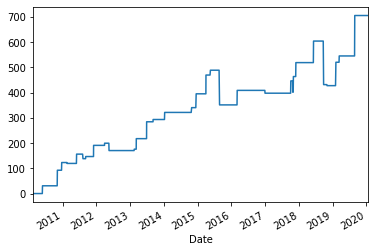

In [9]:
df.long_pnl.cumsum().plot()
plt.show()

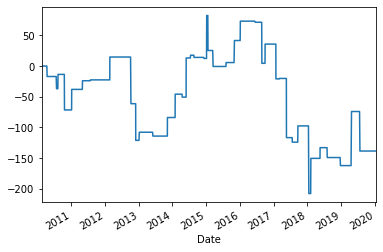

In [10]:
df.short_pnl.cumsum().plot()
plt.show()

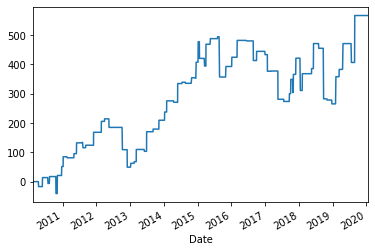

In [11]:
## combine long short pnl 
(df.long_pnl + df.short_pnl).cumsum().plot()
plt.show()

### Now if we want to run stratergy on multiple stocks it is better that we wrap the backtest also inside a function and run that function for all the stocks we want .

In [12]:
def bollinger_band_strat(df):
    
    short_entry = 0
    short_exit = 0

    long_entry = 0
    long_exit = 0

    entered_short = False
    entered_long = False
    
    
    ## we have to calculate rolling mean 
    # we also have to caclulate rolling std 

    df["rolling_mean"] = df.Close.rolling(30).mean()
    df['rolling_std'] = df.Close.rolling(30).std()

    # calculating rolling upper band one 2std above mena  and other 2.5 std above from mean 
    df['upper_band'] = df.rolling_mean + (df.rolling_std * 2)
    df["upper_band2"] = df.rolling_mean + (df.rolling_std * 3)


    # calculating two rolling lower band one 2std below mean and other 2.5 std deviations from mean 
    df['lower_band'] = df.rolling_mean - (df.rolling_std * 2)
    df['lower_band2'] = df.rolling_mean - (df.rolling_std * 3)

    # creting columns to store signals
    df["short_trades"] = 0
    df["long_trades"] = 0

    # creting column to store trade wise pnl
    df["short_pnl"] = 0
    df['long_pnl'] = 0
    
    #first will srop columsn with nan values 
    df.dropna(inplace=True)


    for iter_count,day in enumerate(df.index):


        # first lets check for short
        if (df.iloc[iter_count].loc["Close"] > df.iloc[iter_count].loc["upper_band"]) and (df.iloc[iter_count].loc["Close"] < df.iloc[iter_count].loc["upper_band2"]) and (entered_short == False):
            # we short the stock
            df.iloc[iter_count,7] = -1
            entered_short = True

            #storing short entry price
            short_entry = df.iloc[iter_count].loc["Close"]

        #cheking for short target 
        elif (df.iloc[iter_count].loc["Close"] <= df.iloc[iter_count].loc["rolling_mean"]) and (entered_short == True):

            # we exit the trade as traget met
            df.iloc[iter_count,7] = 1
            entered_short = False

            #storing short exit price 
            short_exit = df.iloc[iter_count].loc["Close"]

            #calculating pnl 
            df.iloc[iter_count,9] = short_entry - short_exit

        # checking for short stop 
        elif (df.iloc[iter_count].loc["Close"] >= df.iloc[iter_count].loc["upper_band2"]) and (entered_short == True):


            # we have to exit as our stop got hit 
            df.iloc[iter_count,7] = 1
            entered_short = False

            #storing short exit price 
            short_exit = df.iloc[iter_count].loc["Close"]


            #calculating pnl 
            df.iloc[iter_count,9] = short_entry - short_exit


        # cheking for entering long trade 
        if (df.iloc[iter_count].loc["Close"] < df.iloc[iter_count].loc["lower_band"]) and (df.iloc[iter_count].loc["Close"] > df.iloc[iter_count].loc["lower_band2"]) and (entered_long == False):
            df.iloc[iter_count,8] = 1
            entered_long = True

            #storing long entry price
            long_entry = df.iloc[iter_count].loc["Close"]

        # checking for long target 
        elif (df.iloc[iter_count].loc["Close"] >= df.iloc[iter_count].loc["rolling_mean"]) and (entered_long == True):
            entered_long = False
            df.iloc[iter_count,8] = -1

            #storing long exit price 
            long_exit = df.iloc[iter_count].loc["Close"]

            # calculating pnl 
            df.iloc[iter_count,10] = long_exit - long_entry

        # storing for long stop
        elif (df.iloc[iter_count].loc["Close"] <= df.iloc[iter_count].loc["lower_band2"]) and (entered_long == True):
            entered_long = False
            df.iloc[iter_count,8] = -1

            #appending long exit price 
            long_exit = df.iloc[iter_count].loc["Close"]

            # calculating pnl
            df.iloc[iter_count,10] = long_exit - long_entry
            
    return df     



In [13]:
# lets load the data 
df = pd.read_csv("DailyHDFCcash.csv",index_col = 0,parse_dates=True)["Close"].to_frame()
df = df.loc["2010":].copy()
df.head()

,Close
Date,
2010-01-04,534.87
2010-01-05,536.69
2010-01-06,539.27
2010-01-07,529.23
2010-01-08,520.01


In [14]:
df = bollinger_band_strat(df)

In [15]:
df.head()

,Close,rolling_mean,rolling_std,upper_band,upper_band2,lower_band,lower_band2,short_trades,long_trades,short_pnl,long_pnl
Date,,,,,,,,,,,
2010-02-15,478.18,495.876000,22.091542,540.059085,562.150627,451.692915,429.601373,0,0,0.0,0.0
2010-02-16,485.64,494.235000,20.890939,536.016878,556.907816,452.453122,431.562184,0,0,0.0,0.0
2010-02-17,492.79,492.771667,19.290813,531.353294,550.644107,454.190040,434.899226,0,0,0.0,0.0
2010-02-18,496.19,491.335667,17.200297,525.736260,542.936557,456.935073,439.734776,0,0,0.0,0.0
2010-02-19,496.00,490.228000,15.678476,521.584952,537.263429,458.871048,443.192571,0,0,0.0,0.0


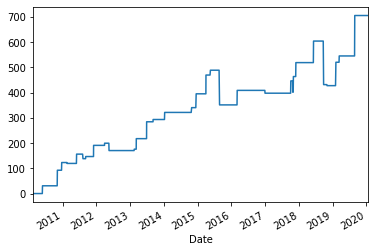

In [16]:
df.long_pnl.cumsum().plot()

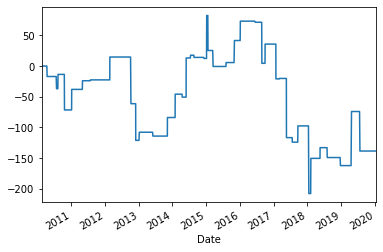

In [17]:
df.short_pnl.cumsum().plot()

In [31]:
### now lets apply our function to list of stocks 


In [20]:
import os
all_csv_name = [stock_name for stock_name in os.listdir() if "csv" in stock_name]
all_csv_name

['DailyHDFCcash.csv',
 'DailyNIFTYBANKcash.csv',
 'DailyNIFTYcash.csv',
 'DailyRELIANCEcash.csv',
 'DailySBINcash.csv',
 'DailyTATAMOTORScash.csv']

In [39]:
%%time
# we will be running our bollinger band stratergy on all the stocks and storing stocks results in dict with thier name as key  
stratergy_df = pd.DataFrame(index = df.index)
record = {}

for stock_csv in all_csv_name:
    df = pd.read_csv(stock_csv,index_col = 0,parse_dates=True)["Close"].to_frame()
    df = df.loc["2010-jan":].copy()
    df.sort_index(inplace = True)
    df = bollinger_band_strat(df)
    df["combine_pnl"] = (df.long_pnl + df.short_pnl)/df.Close
    record[stock_csv] = df 
    
    # storing all stocsk retuslts in one df 
    stratergy_df[stock_csv] = (df.long_pnl + df.short_pnl)/df.Close
    

Wall time: 30.5 s


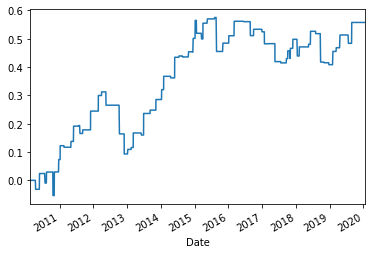

In [40]:
record['DailyHDFCcash.csv'].combine_pnl.cumsum().plot()

In [ ]:
record

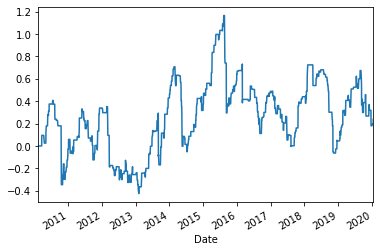

In [41]:
stratergy_df.sum(axis = 1).cumsum().plot()

## Performance metrics 

In [42]:
df = record['DailyHDFCcash.csv']

In [43]:
df.loc[ df.combine_pnl != 0]

,Close,rolling_mean,rolling_std,upper_band,upper_band2,lower_band,lower_band2,short_trades,long_trades,short_pnl,long_pnl,combine_pnl
Date,,,,,,,,,,,,
2010-04-15,537.94,538.484333,15.908675,570.301683,586.210358,506.666984,490.758309,1,0,-17.01,0.00,-0.031621
2010-05-27,552.76,550.228000,11.884506,573.997013,585.881519,526.458987,514.574481,0,-1,0.00,30.74,0.055612
2010-07-26,591.71,594.054667,10.731005,615.516677,626.247682,572.592656,561.861651,1,0,-19.90,0.00,-0.033631
2010-08-11,599.75,599.761000,11.756780,623.274561,635.031341,576.247439,564.490659,1,0,23.36,0.00,0.038950
2010-10-20,697.90,712.275000,31.438544,775.152087,806.590631,649.397913,617.959369,1,0,-57.95,0.00,-0.083035
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-04,1978.50,1966.196667,30.499327,2027.195321,2057.694648,1905.198012,1874.698685,0,-1,0.00,92.70,0.046854
2019-03-12,1930.00,1903.921667,43.071960,1990.065587,2033.137547,1817.777747,1774.705787,0,-1,0.00,24.95,0.012927
2019-04-22,1953.90,1978.918333,50.521012,2079.960358,2130.481370,1877.876309,1827.355297,1,0,88.15,0.00,0.045115


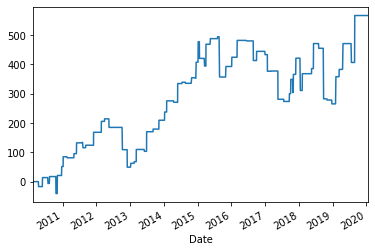

In [43]:
df.combine_pnl.cumsum().plot()

## calculating performance metrics 

In [ ]:
import performance_metrics

In [33]:
# lets convert points returns to percentage returns 
returns  = (df.loc[ df.combine_pnl != 0].combine_pnl/df.loc[ df.combine_pnl != 0].Close)

In [29]:
performance_metrics.sharpe_ratio(returns)

2.718842385641664

In [30]:
performance_metrics.CAGR(returns)

4.386394935163449

In [31]:
performance_metrics.drawdown(returns)

0.20418034655512604

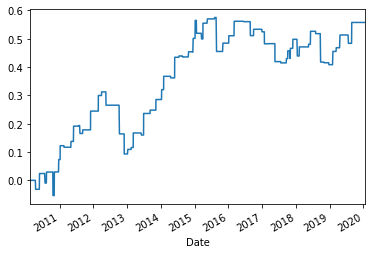

In [38]:
(df.combine_pnl/df.Close).cumsum().plot()

## Have a look at our full course ** Python for algorithmic trading **
* [click here to get pdf](http://www.dravyaniti.com/PDF/PAT.pdf)